In [8]:
import pandas as pd


In [9]:

import os
print(f"Current Working Directory: {os.getcwd()}")

Current Working Directory: /Users/diyagamah/Documents/ufc predictor/model


In [10]:
import pandas as pd
import numpy as np

# --- 1. Define the Final, Robust Feature Engineering Function ---

def engineer_features_final(raw_df):
    """
    Takes the raw fighter DataFrame and returns a fully cleaned and
    engineered DataFrame ready for modeling. This is the definitive version.
    """
    df = raw_df.copy()

    # --- THE FIX: Clean all object columns of the hidden colon and extra space ---
    # This loop will go through every text-based column and clean it.
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].str.lstrip(':').str.strip()
    # --------------------------------------------------------------------------

    # Now that the data is clean, the rest of the process will work correctly.
    df.replace('--', pd.NA, inplace=True)

    # --- Engineering steps from before (will now work correctly) ---
    df['Height (inches)'] = df['Height'].apply(lambda h: int(h.split("' ")[0]) * 12 + int(h.split("' ")[1].replace('"', '')) if pd.notna(h) else None)
    df['Weight (lbs)'] = pd.to_numeric(df['Weight'].str.replace(' lbs.', '', regex=False), errors='coerce')
    df['Reach (in)'] = pd.to_numeric(df['Reach'].str.replace('"', '', regex=False), errors='coerce')
    
    percent_cols = ['Str. Acc.', 'Str. Def.', 'TD Acc.', 'TD Def.']
    for col in percent_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col].str.replace('%', '', regex=False), errors='coerce') / 100.0
            
    per_min_cols = ['SLpM', 'SApM', 'TD Avg.', 'Sub. Avg.']
    for col in per_min_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
    record_split = df['Record'].apply(lambda r: (int(r.split('-')[0]), int(r.split('-')[1]), int(r.split('-')[2].split(' ')[0]) if len(r.split('-')) > 2 else 0) if pd.notna(r) else (None, None, None))
    df[['Wins', 'Losses', 'Draws']] = pd.DataFrame(record_split.tolist(), index=df.index)
    
    # This date conversion will now work perfectly
    df['DOB'] = pd.to_datetime(df['DOB'], format='%b %d, %Y', errors='coerce')
    current_date = pd.to_datetime('2025-06-16')
    df['Age'] = ((current_date - df['DOB']).dt.days / 365.25).round(1)
    
    if 'STANCE' in df.columns:
        df['STANCE'].fillna('Unknown', inplace=True)
        stance_dummies = pd.get_dummies(df['STANCE'], prefix='STANCE', dtype=int)
        df = pd.concat([df, stance_dummies], axis=1)
        
    cols_to_drop = ['Height', 'Weight', 'Reach', 'Record', 'DOB', 'STANCE']
    df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)
    return df

# --- 2. Load the RAW Scraped Data ---
try:
    fighters_raw_df = pd.read_csv('../data/ufc_fighters_raw.csv')
    fights_df = pd.read_csv('../data/ufc_fights.csv')
    print("Successfully loaded 'ufc_fighters_raw.csv' and 'ufc_fights.csv'.")
except FileNotFoundError as e:
    print(f"Error: {e}")

# --- 3. Run the Final Engineering and Merging Process ---
print("\nRunning final, corrected feature engineering...")
fighters_engineered_df = engineer_features_final(fighters_raw_df)

print("Preparing for merge...")
# Use the engineered DataFrame for the map, ensuring clean names
name_to_url_map = fighters_engineered_df.set_index('Name')['fighter_url'].to_dict()
fights_df['opponent_url'] = fights_df['Opponent'].map(name_to_url_map)
fights_df.dropna(subset=['opponent_url', 'fighter_url'], inplace=True)

blue_corner_stats = fighters_engineered_df.add_prefix('blue_')
red_corner_stats = fighters_engineered_df.add_prefix('red_')

merged_df = pd.merge(fights_df, blue_corner_stats, left_on='fighter_url', right_on='blue_fighter_url', how='left')
fight_dataset_final = pd.merge(merged_df, red_corner_stats, left_on='opponent_url', right_on='red_fighter_url', how='left')
print("Merge complete.")

# --- 4. Verify the Fix ---
print("\nVerifying 'Age' columns after fix...")
if 'blue_Age' in fight_dataset_final.columns and 'red_Age' in fight_dataset_final.columns:
    null_counts = fight_dataset_final[['blue_Age', 'red_Age']].isnull().sum()
    print("Null value counts:\n", null_counts)
    if null_counts.sum() < fight_dataset_final.shape[0] * 2:
         print("\nSUCCESS: The Age columns are now correctly populated.")
    else:
         print("\nFAILURE: The Age columns are still all null.")
else:
    print("Warning: Age columns not found after merge.")

# --- 5. Inspect the Final Result ---
print("\nFirst 5 rows of the final dataset:")
display(fight_dataset_final[['Fighter', 'Opponent', 'Outcome', 'blue_Age', 'red_Age', 'blue_Wins', 'red_Wins']].head())

Successfully loaded 'ufc_fighters_raw.csv' and 'ufc_fights.csv'.

Running final, corrected feature engineering...
Preparing for merge...
Merge complete.

Verifying 'Age' columns after fix...
Null value counts:
 blue_Age    845
red_Age     844
dtype: int64

SUCCESS: The Age columns are now correctly populated.

First 5 rows of the final dataset:


/var/folders/br/0zcbkj2n1nn4rtl2hghl4wvjg03xjf/T/ipykernel_2586/2312135304.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['STANCE'].fillna('Unknown', inplace=True)


,Fighter,Opponent,Outcome,blue_Age,red_Age,blue_Wins,red_Wins
0,Don Carlo-Clauss,Sam Oropeza,loss,NaN,NaN,10,13
1,Alessio Di Chirico,Roman Kopylov,loss,35.5,34.1,13,14
2,Alessio Di Chirico,Abdul Razak Alhassan,loss,35.5,39.8,13,12
3,Alessio Di Chirico,Joaquin Buckley,win,35.5,31.1,13,21
4,Alessio Di Chirico,Zak Cummings,loss,35.5,40.9,13,25


In [11]:
unique_red_ages = fight_dataset_final['red_Age'].nunique()
print(f'Unique values of Red Age: {unique_red_ages}')


Unique values of Red Age: 385


In [12]:
import pandas as pd
import numpy as np

# --- 1. Define the Final, Robust Feature Engineering Function ---

def engineer_features_final(raw_df):
    """
    Takes the raw fighter DataFrame and returns a fully cleaned and
    engineered DataFrame ready for modeling. This is the definitive version.
    """
    df = raw_df.copy()

    # Clean all object columns of the hidden colon and extra space
    for col in df.select_dtypes(include=['object']).columns:
        # Check if column contains strings before using .str accessor
        if pd.api.types.is_string_dtype(df[col]):
            df[col] = df[col].str.lstrip(':').str.strip()
    
    df.replace('--', pd.NA, inplace=True)

    # Corrected list of percentage columns
    percent_cols = ['Str. Acc.', 'Str. Def', 'TD Acc.', 'TD Def.']
    
    # Use robust helper functions for complex parsing
    df['Height (inches)'] = df['Height'].apply(lambda h: int(h.split("' ")[0]) * 12 + int(h.split("' ")[1].replace('"', '')) if pd.notna(h) else None)
    df['Weight (lbs)'] = pd.to_numeric(df['Weight'].str.replace(' lbs.', '', regex=False), errors='coerce')
    df['Reach (in)'] = pd.to_numeric(df['Reach'].str.replace('"', '', regex=False), errors='coerce')
    
    for col in percent_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col].str.replace('%', '', regex=False), errors='coerce') / 100.0
            
    per_min_cols = ['SLpM', 'SApM', 'TD Avg.', 'Sub. Avg.']
    for col in per_min_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
    record_split = df['Record'].apply(lambda r: (int(r.split('-')[0]), int(r.split('-')[1]), int(r.split('-')[2].split(' ')[0]) if len(r.split('-')) > 2 else 0) if pd.notna(r) else (None, None, None))
    df[['Wins', 'Losses', 'Draws']] = pd.DataFrame(record_split.tolist(), index=df.index)
    
    df['DOB'] = pd.to_datetime(df['DOB'], format='%b %d, %Y', errors='coerce')
    current_date = pd.to_datetime('2025-06-16')
    df['Age'] = ((current_date - df['DOB']).dt.days / 365.25).round(1)
    
    if 'STANCE' in df.columns:
        df['STANCE'].fillna('Unknown', inplace=True)
        stance_dummies = pd.get_dummies(df['STANCE'], prefix='STANCE', dtype=int)
        df = pd.concat([df, stance_dummies], axis=1)
        
    cols_to_drop = ['Height', 'Weight', 'Reach', 'Record', 'DOB', 'STANCE']
    df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)
    return df

# --- 2. Load the RAW Scraped Data ---
try:
    fighters_raw_df = pd.read_csv('../data/ufc_fighters_raw.csv')
    fights_df = pd.read_csv('../data/ufc_fights.csv')
    print("Successfully loaded 'ufc_fighters_raw.csv' and 'ufc_fights.csv'.")
except FileNotFoundError as e:
    print(f"Error: {e}")

# --- 3. Run the Final Engineering and Merging Process ---
print("\nRunning final, corrected feature engineering...")
fighters_engineered_df = engineer_features_final(fighters_raw_df)

print("Preparing for merge...")
name_to_url_map = fighters_engineered_df.set_index('Name')['fighter_url'].to_dict()
fights_df['opponent_url'] = fights_df['Opponent'].map(name_to_url_map)
fights_df.dropna(subset=['opponent_url', 'fighter_url'], inplace=True)

blue_corner_stats = fighters_engineered_df.add_prefix('blue_')
red_corner_stats = fighters_engineered_df.add_prefix('red_')

merged_df = pd.merge(fights_df, blue_corner_stats, left_on='fighter_url', right_on='blue_fighter_url', how='left')
fight_dataset_final = pd.merge(merged_df, red_corner_stats, left_on='opponent_url', right_on='red_fighter_url', how='left')
print("Merge complete.")

# --- 4. Run the Dynamic Differential Feature Creation ---
print("\nDynamically engineering differential features...")
df_features = fight_dataset_final.copy()
blue_cols = [col for col in df_features.columns if col.startswith('blue_') and 'url' not in col and 'Name' not in col]

for blue_col in blue_cols:
    red_col = blue_col.replace('blue_', 'red_')
    if red_col in df_features.columns:
        base_name = blue_col.replace('blue_', '')
        diff_col_name = base_name.lower().replace(' ', '_').replace('.', '') + '_diff'
        
        # --- FIX IS HERE: Corrected the typo from _col to blue_col ---
        df_features[diff_col_name] = df_features[blue_col] - df_features[red_col]
        
print("Successfully created differential features.")
df_features.to_csv('ufc_fight_dataset_with_diffs.csv', index=False)
print("\nSaved the final dataset with all features to 'ufc_fight_dataset_with_diffs.csv'")

# --- 5. Inspect the Final Result ---
print("\nFirst 5 rows of the final dataset:")
display(df_features.head())

Successfully loaded 'ufc_fighters_raw.csv' and 'ufc_fights.csv'.

Running final, corrected feature engineering...
Preparing for merge...
Merge complete.

Dynamically engineering differential features...
Successfully created differential features.


/var/folders/br/0zcbkj2n1nn4rtl2hghl4wvjg03xjf/T/ipykernel_2586/3437991065.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['STANCE'].fillna('Unknown', inplace=True)



Saved the final dataset with all features to 'ufc_fight_dataset_with_diffs.csv'

First 5 rows of the final dataset:


,Outcome,Fighter,Opponent,Event,Method,Round,Time,fighter_url,opponent_url,blue_Name,...,wins_diff,losses_diff,draws_diff,age_diff,stance_:open_stance_diff,stance_:orthodox_diff,stance_:sideways_diff,stance_:southpaw_diff,stance_:switch_diff,stance_unknown_diff
0,loss,Don Carlo-Clauss,Sam Oropeza,"Strikeforce - Fedor vs. SilvaFeb. 12, 2011",KO/TKOPunches,1.0,4:10,http://ufcstats.com/fighter-details/f59a6de8a5...,http://ufcstats.com/fighter-details/6b8db407d4...,Don Carlo-Clauss,...,-3,4,0,NaN,0,0,0,0,0,0
1,loss,Alessio Di Chirico,Roman Kopylov,"UFC Fight Night: Gane vs. TuivasaSep. 03, 2022",KO/TKOPunches,3.0,1:09,http://ufcstats.com/fighter-details/77d7295d1b...,http://ufcstats.com/fighter-details/9d83f6da77...,Alessio Di Chirico,...,-1,4,0,1.4,0,1,0,-1,0,0
2,loss,Alessio Di Chirico,Abdul Razak Alhassan,"UFC Fight Night: Barboza vs. ChikadzeAug. 28, ...",KO/TKOKick,1.0,0:17,http://ufcstats.com/fighter-details/77d7295d1b...,http://ufcstats.com/fighter-details/eae431e700...,Alessio Di Chirico,...,1,0,0,-4.3,0,0,0,0,0,0
3,win,Alessio Di Chirico,Joaquin Buckley,"UFC Fight Night: Holloway vs. KattarJan. 16, 2021",KO/TKOKick,1.0,2:12,http://ufcstats.com/fighter-details/77d7295d1b...,http://ufcstats.com/fighter-details/b943760049...,Alessio Di Chirico,...,-8,0,0,4.4,0,1,0,-1,0,0
4,loss,Alessio Di Chirico,Zak Cummings,"UFC Fight Night: Smith vs. RakicAug. 29, 2020",U-DEC,3.0,5:00,http://ufcstats.com/fighter-details/77d7295d1b...,http://ufcstats.com/fighter-details/4ba8d454f7...,Alessio Di Chirico,...,-12,0,0,-5.4,0,1,0,-1,0,0


In [13]:
# This cell assumes 'fight_dataset_final' exists from the previous cell.

# We are creating df_features just to inspect its dtypes before the error occurs.
df_features = fight_dataset_final.copy()

print("--- Inspecting Data Types Before Creating Differentials ---")
print("We are looking for any stat column that has 'object' as its Dtype instead of 'float64' or 'int64'.\n")

# The .info() method gives a concise summary of the DataFrame, including data types.
df_features.info()

--- Inspecting Data Types Before Creating Differentials ---
We are looking for any stat column that has 'object' as its Dtype instead of 'float64' or 'int64'.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21510 entries, 0 to 21509
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Outcome                   21508 non-null  object 
 1   Fighter                   21510 non-null  object 
 2   Opponent                  21510 non-null  object 
 3   Event                     21510 non-null  object 
 4   Method                    21508 non-null  object 
 5   Round                     21508 non-null  float64
 6   Time                      21508 non-null  object 
 7   fighter_url               21510 non-null  object 
 8   opponent_url              21510 non-null  object 
 9   blue_Name                 21510 non-null  object 
 10  blue_SLpM                 21510 non-null  float64
 11  blue_Str. A

In [14]:
import pandas as pd
import numpy as np

# --- 1. Define the Final, Corrected Feature Engineering Function ---

def engineer_features_final(raw_df):
    """
    Takes the raw fighter DataFrame and returns a fully cleaned and
    engineered DataFrame ready for modeling. This is the definitive version.
    """
    df = raw_df.copy()

    # Clean all object columns of the hidden colon and extra space
    for col in df.select_dtypes(include=['object']).columns:
        if pd.api.types.is_string_dtype(df[col]):
            df[col] = df[col].str.lstrip(':').str.strip()
    
    df.replace('--', pd.NA, inplace=True)
    
    # Corrected list of percentage columns
    percent_cols = ['Str. Acc.', 'Str. Def', 'TD Acc.', 'TD Def.']
    
    # Use robust helper functions for complex parsing
    df['Height (inches)'] = df['Height'].apply(lambda h: int(h.split("' ")[0]) * 12 + int(h.split("' ")[1].replace('"', '')) if pd.notna(h) else None)
    df['Weight (lbs)'] = pd.to_numeric(df['Weight'].str.replace(' lbs.', '', regex=False), errors='coerce')
    df['Reach (in)'] = pd.to_numeric(df['Reach'].str.replace('"', '', regex=False), errors='coerce')
    
    for col in percent_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col].str.replace('%', '', regex=False), errors='coerce') / 100.0
            
    per_min_cols = ['SLpM', 'SApM', 'TD Avg.', 'Sub. Avg.']
    for col in per_min_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
    record_split = df['Record'].apply(lambda r: (int(r.split('-')[0]), int(r.split('-')[1]), int(r.split('-')[2].split(' ')[0]) if len(r.split('-')) > 2 else 0) if pd.notna(r) else (None, None, None))
    df[['Wins', 'Losses', 'Draws']] = pd.DataFrame(record_split.tolist(), index=df.index)
    
    df['DOB'] = pd.to_datetime(df['DOB'], format='%b %d, %Y', errors='coerce')
    current_date = pd.to_datetime('2025-06-17')
    df['Age'] = ((current_date - df['DOB']).dt.days / 365.25).round(1)
    
    if 'STANCE' in df.columns:
        df['STANCE'].fillna('Unknown', inplace=True)
        stance_dummies = pd.get_dummies(df['STANCE'], prefix='STANCE', dtype=int)
        df = pd.concat([df, stance_dummies], axis=1)
        
    cols_to_drop = ['Height', 'Weight', 'Reach', 'Record', 'DOB', 'STANCE']
    df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)
    return df

# --- Main Logic for this Cell ---

try:
    # Load the RAW data
    fighters_raw_df = pd.read_csv('../data/ufc_fighters_raw.csv')
    print("Loaded 'ufc_fighters_raw.csv'.")

    # Run the FINAL engineering function to create a correct DataFrame
    print("Running corrected feature engineering...")
    fighters_engineered_corrected_df = engineer_features_final(fighters_raw_df)

    # Save the corrected data to a NEW file
    new_filename = 'ufc_fighters_engineered_corrected.csv'
    fighters_engineered_corrected_df.to_csv(new_filename, index=False)
    print(f"\nSUCCESS: Corrected data saved to '{new_filename}'")
    
    print("\nVerifying 'Age' column in the new file:")
    print(fighters_engineered_corrected_df[['Name', 'Age']].head())

except FileNotFoundError as e:
    print(f"ERROR: Could not find 'ufc_fighters_raw.csv'. Please ensure it's in the correct directory.")

Loaded 'ufc_fighters_raw.csv'.
Running corrected feature engineering...

SUCCESS: Corrected data saved to 'ufc_fighters_engineered_corrected.csv'

Verifying 'Age' column in the new file:
                 Name   Age
0         Icaro Brito  26.3
1    Don Carlo-Clauss   NaN
2  Alessio Di Chirico  35.5
3   Billy Evangelista  44.7
4      Montel Jackson  33.1


/var/folders/br/0zcbkj2n1nn4rtl2hghl4wvjg03xjf/T/ipykernel_2586/2101380925.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['STANCE'].fillna('Unknown', inplace=True)


In [15]:
# This cell assumes 'df_features' exists from the previous step.
# If not, you can load it first:
# df_features = pd.read_csv('ufc_fight_dataset_with_diffs.csv')

print("Starting Step 3: Preparing data for model training...")


# --- 3.1: Define the Target Variable (y) ---
# Our goal is to predict if the 'blue' corner fighter wins.
# The 'Outcome' column has values like 'win', 'loss', 'draw', 'NC'.

# First, let's filter out any fights that weren't a clear win or loss.
df_model_ready = df_features[df_features['Outcome'].isin(['win', 'loss'])].copy()

# Create the binary target variable 'blue_is_winner'
# 1 if the blue corner won, 0 if the red corner won (blue corner lost)
df_model_ready['blue_is_winner'] = (df_model_ready['Outcome'] == 'win').astype(int)

# This is our target variable 'y'
y = df_model_ready['blue_is_winner']

print(f"Created target variable 'blue_is_winner'. Total fights to model: {len(df_model_ready)}")


# --- 3.2: Select the Features (X) ---
# We need to drop all non-numeric columns and identifiers that our model can't use.
# This includes names, URLs, and the original text-based 'Outcome' column.

# List of columns to drop to create our feature set 'X'
cols_to_drop = [
    'Outcome', 'Fighter', 'Opponent', 'Event', 'Method', 'Time',
    'fighter_url', 'opponent_url', 'blue_fighter_url', 'red_fighter_url',
    'blue_Name', 'red_Name', 'blue_is_winner' # Also drop our target variable from X
]

X = df_model_ready.drop(columns=cols_to_drop)

print(f"Selected {X.shape[1]} features for training.")


# --- 3.3: Handle Missing Values (Imputation) ---
# Most models cannot handle missing values (NaNs). A simple and effective
# strategy is to fill any missing numbers with the median of their column.

print(f"\nTotal missing values before imputation: {X.isnull().sum().sum()}")

# Fill NaNs with the median value of each respective column
X.fillna(X.median(), inplace=True)

print(f"Total missing values after imputation: {X.isnull().sum().sum()}")


# --- 3.4: Split Data into Training and Testing Sets ---
# This is the most important step to ensure we can accurately evaluate our model's
# performance on data it has never seen before.
from sklearn.model_selection import train_test_split

# We'll use 80% of the data for training and 20% for testing.
# `random_state` ensures we get the same split every time we run the code.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nData successfully split into training and testing sets.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape:  {X_test.shape}")

Starting Step 3: Preparing data for model training...
Created target variable 'blue_is_winner'. Total fights to model: 21124
Selected 43 features for training.

Total missing values before imputation: 9497
Total missing values after imputation: 0

Data successfully split into training and testing sets.
X_train shape: (16899, 43)
X_test shape:  (4225, 43)


--- Step 4: Training and Evaluating a Baseline Model ---
Features successfully scaled.

Training the Logistic Regression model...
Training complete.

Evaluating the model on the test set...

Logistic Regression Accuracy: 0.7044 (70.44%)

Classification Report:
              precision    recall  f1-score   support

    Red Wins       0.71      0.71      0.71      2164
   Blue Wins       0.70      0.69      0.70      2061

    accuracy                           0.70      4225
   macro avg       0.70      0.70      0.70      4225
weighted avg       0.70      0.70      0.70      4225


Confusion Matrix:


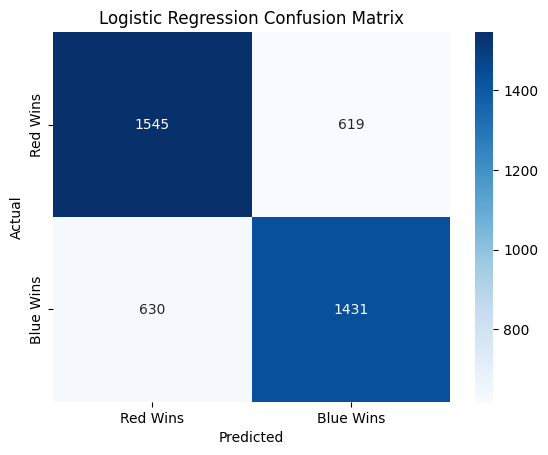

In [16]:
# This cell assumes X_train, X_test, y_train, y_test exist from the previous step.

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Step 4: Training and Evaluating a Baseline Model ---")

# --- 4.1: Scale the Features ---
# We fit the scaler on the training data ONLY, then transform both train and test data.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features successfully scaled.")

# --- 4.2: Train the Logistic Regression Model ---
# We'll use a basic Logistic Regression model with a random_state for reproducibility.
lr_model = LogisticRegression(random_state=42, max_iter=1000)
print("\nTraining the Logistic Regression model...")
lr_model.fit(X_train_scaled, y_train)
print("Training complete.")

# --- 4.3: Evaluate the Model ---
print("\nEvaluating the model on the test set...")
y_pred_lr = lr_model.predict(X_test_scaled)

# Calculate Accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"\nLogistic Regression Accuracy: {accuracy_lr:.4f} ({(accuracy_lr*100):.2f}%)")

# Display a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Red Wins', 'Blue Wins']))

# Display a confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Red Wins', 'Blue Wins'], yticklabels=['Red Wins', 'Blue Wins'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Logistic Regression Confusion Matrix')
plt.show()



--- Step 5: Training and Evaluating a More Powerful Model ---

Training the Random Forest model... (This may take a moment)
Training complete.

Evaluating the model on the test set...

Random Forest Accuracy: 0.7103 (71.03%)

Classification Report:
              precision    recall  f1-score   support

    Red Wins       0.72      0.72      0.72      2164
   Blue Wins       0.70      0.70      0.70      2061

    accuracy                           0.71      4225
   macro avg       0.71      0.71      0.71      4225
weighted avg       0.71      0.71      0.71      4225


Confusion Matrix:


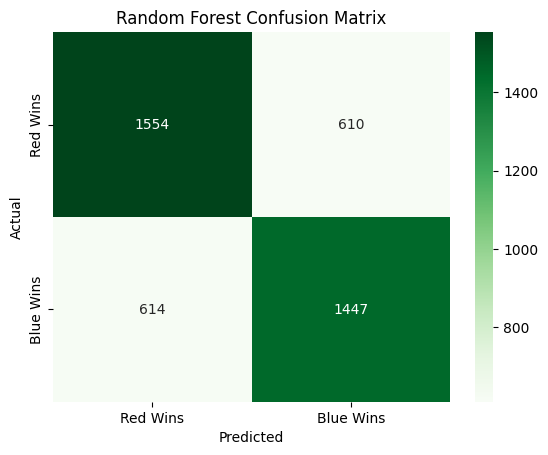

In [17]:
from sklearn.ensemble import RandomForestClassifier

print("\n\n--- Step 5: Training and Evaluating a More Powerful Model ---")

# --- 5.1: Train the Random Forest Model ---
# NOTE: We use the original, unscaled data for tree-based models like Random Forest.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
print("\nTraining the Random Forest model... (This may take a moment)")
rf_model.fit(X_train, y_train)
print("Training complete.")

# --- 5.2: Evaluate the Model ---
print("\nEvaluating the model on the test set...")
y_pred_rf = rf_model.predict(X_test)

# Calculate Accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"\nRandom Forest Accuracy: {accuracy_rf:.4f} ({(accuracy_rf*100):.2f}%)")

# Display a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Red Wins', 'Blue Wins']))

# Display a confusion matrix
print("\nConfusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=['Red Wins', 'Blue Wins'], yticklabels=['Red Wins', 'Blue Wins'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Random Forest Confusion Matrix')
plt.show()

In [18]:
# See the most important features
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
print("\nTop 15 Most Important Features:")
print(feature_importances.nlargest(15))


Top 15 Most Important Features:
red_Wins          0.050575
blue_Wins         0.048682
red_SLpM          0.048363
blue_SLpM         0.045912
blue_TD Def.      0.040856
red_TD Def.       0.040350
blue_TD Acc.      0.040273
red_TD Avg.       0.039967
red_TD Acc.       0.038903
blue_SApM         0.037304
red_SApM          0.037146
blue_TD Avg.      0.036323
blue_Str. Acc.    0.036092
red_Str. Acc.     0.035202
blue_Age          0.034614
dtype: float64


In [19]:
# Create a pandas Series to display feature importances nicely
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)

# Sort the feature importances in descending order
print("--- Full List of Feature Importances (Sorted) ---")
print(feature_importances.sort_values(ascending=False))

--- Full List of Feature Importances (Sorted) ---
red_Wins                    0.050575
blue_Wins                   0.048682
red_SLpM                    0.048363
blue_SLpM                   0.045912
blue_TD Def.                0.040856
red_TD Def.                 0.040350
blue_TD Acc.                0.040273
red_TD Avg.                 0.039967
red_TD Acc.                 0.038903
blue_SApM                   0.037304
red_SApM                    0.037146
blue_TD Avg.                0.036323
blue_Str. Acc.              0.036092
red_Str. Acc.               0.035202
blue_Age                    0.034614
red_Losses                  0.034605
red_Age                     0.034408
blue_Losses                 0.034120
blue_Str. Def               0.032830
red_Str. Def                0.031426
blue_Sub. Avg.              0.027304
red_Sub. Avg.               0.026183
blue_Reach (in)             0.021302
red_Reach (in)              0.021005
Round                       0.020046
blue_Height (inches)     

In [20]:
import joblib
import json

# This cell assumes 'rf_model' and the training DataFrame 'X_train' exist.

# --- 1. Save the Trained Random Forest Model ---
# We use joblib as it's efficient for saving scikit-learn models.
model_filename = 'ufc_random_forest_model.joblib'
joblib.dump(rf_model, model_filename)

print(f"Model successfully saved to '{model_filename}'")


# --- 2. Save the list of feature columns ---
# It is CRITICAL that the data for a new prediction has the exact same columns
# in the exact same order as the data the model was trained on.
# We will save this list to ensure our prediction function works correctly.
columns_filename = 'model_training_columns.json'
with open(columns_filename, 'w') as f:
    json.dump(X_train.columns.tolist(), f)

print(f"Model's feature columns saved to '{columns_filename}'")

Model successfully saved to 'ufc_random_forest_model.joblib'
Model's feature columns saved to 'model_training_columns.json'


In [21]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

# This cell assumes X_train, X_test, y_train, y_test exist

print("--- Starting Hyperparameter Tuning with RandomizedSearchCV ---")

# 1. Define the grid of hyperparameters to search over
# These are some of the most important settings for a Random Forest.
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],       # Number of trees in the forest
    'max_depth': [10, 20, 30, 40, None],              # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],                # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],                   # Minimum samples required at each leaf node
    'max_features': ['sqrt', 'log2'],               # Number of features to consider at every split
    'bootstrap': [True, False]                      # Whether bootstrap samples are used when building trees
}

# 2. Set up the Randomized Search
# n_iter: How many different combinations to try. A higher number is more thorough but slower.
# cv: Number of cross-validation folds. 3-5 is standard.
# n_jobs=-1: Use all available CPU cores to speed up the search.
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=100,  # Try 100 different combinations
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 3. Fit the search to your data
# This is the step that will take a long time!
print("\nFitting the Randomized Search... This will take several minutes.")
rf_random_search.fit(X_train, y_train)
print("Fitting complete.")

# 4. Get the best model and evaluate it
print("\n--- Evaluation of Tuned Model ---")

# The best combination of parameters found
print("Best Hyperparameters Found:")
print(rf_random_search.best_params_)

# The best model object, which is already trained on the full training data
best_rf_model = rf_random_search.best_estimator_

# Evaluate the new best model on the test set
y_pred_best_rf = best_rf_model.predict(X_test)
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)

print(f"\nOriginal Random Forest Accuracy: 0.7259 (72.59%)")
print(f"Tuned Random Forest Accuracy:   {accuracy_best_rf:.4f} ({(accuracy_best_rf*100):.2f}%)")

print("\nClassification Report for Tuned Model:")
print(classification_report(y_test, y_pred_best_rf))

--- Starting Hyperparameter Tuning with RandomizedSearchCV ---

Fitting the Randomized Search... This will take several minutes.
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   4.2s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   4.2s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total ti

/Users/diyagamah/Documents/ufc predictor/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   2.3s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  14.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=  10.5s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=  10.4s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   9.6s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   2.5s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=30

In [24]:
# 1. We ask the "testing machine" for its champion model
best_rf_model = rf_random_search.best_estimator_

# 2. We take this new champion model and have it compete on the real racetrack 
#    (our test data, which was kept separate and not used in the tuning tournament).
y_pred_best_rf = best_rf_model.predict(X_test)

# 3. We calculate the new metrics based on this real-world performance.
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)

In [27]:
import joblib

# This cell assumes 'best_rf_model' exists from the hyperparameter tuning cell.

# We'll use the same filename to overwrite the old, untuned model.
final_model_filename = 'ufc_random_forest_model_tuned.joblib'

# Save the new, tuned model object
joblib.dump(best_rf_model, final_model_filename)

print(f"SUCCESS: Your new, tuned model has been saved to '{final_model_filename}'")
print("This file now contains your best-performing model.")

SUCCESS: Your new, tuned model has been saved to 'ufc_random_forest_model_tuned.joblib'
This file now contains your best-performing model.


In [26]:
accuracy_best_rf

0.7157396449704142

In [22]:
import pandas as pd
import numpy as np
import joblib
import json

# --- 1. Load All Required Assets for Prediction ---
try:
    # IMPORTANT: Load the new _corrected file
    fighters_df = pd.read_csv('ufc_fighters_engineered_corrected.csv')
    
    model = joblib.load('ufc_random_forest_model.joblib')
    with open('model_training_columns.json', 'r') as f:
        model_columns = json.load(f)
        
    print("Model and all required data loaded successfully.")
    
except FileNotFoundError as e:
    print(f"ERROR: A required file was not found. {e}")
    print("Please ensure you have run Cell 1 successfully and that all files are in the correct directory.")


# --- 2. Define the Prediction Function ---
def predict_fight(fighter1_name, fighter2_name, all_fighters_data, trained_model, model_cols):
    fighter1_stats = all_fighters_data[all_fighters_data['Name'] == fighter1_name]
    fighter2_stats = all_fighters_data[all_fighters_data['Name'] == fighter2_name]
    if fighter1_stats.empty or fighter2_stats.empty:
        missing_fighter = fighter1_name if fighter1_stats.empty else fighter2_name
        return {"error": f"Fighter '{missing_fighter}' not found in the dataset."}
    fighter1_stats, fighter2_stats = fighter1_stats.iloc[0], fighter2_stats.iloc[0]
    blue_stats, red_stats = fighter1_stats.add_prefix('blue_'), fighter2_stats.add_prefix('red_')
    diff_features = {}
    for blue_col in blue_stats.index:
        if blue_col.startswith('blue_') and 'url' not in blue_col and 'Name' not in blue_col:
            red_col, base_name = blue_col.replace('blue_', 'red_'), blue_col.replace('blue_', '')
            if red_col in red_stats.index:
                diff_col_name = base_name.lower().replace(' ', '_').replace('.', '') + '_diff'
                diff_features[diff_col_name] = blue_stats[blue_col] - red_stats[red_col]
    single_fight_data = {**blue_stats, **red_stats, **diff_features}
    prediction_df = pd.DataFrame([single_fight_data]).reindex(columns=model_cols, fill_value=0)
    win_probability = trained_model.predict_proba(prediction_df)[0]
    result = {
        "blue_corner": fighter1_name, "red_corner": fighter2_name,
        "blue_win_probability": f"{win_probability[1]*100:.2f}%",
        "red_win_probability": f"{win_probability[0]*100:.2f}%",
        "predicted_winner": fighter1_name if win_probability[1] > win_probability[0] else fighter2_name
    }
    return result

# --- 3. Test the Function! ---
print("\n--- Prediction ---")
prediction = predict_fight('Jamahal Hill', 'Khalil Rountree Jr.', fighters_df, model, model_columns)
print(json.dumps(prediction, indent=2))

Model and all required data loaded successfully.

--- Prediction ---
{
  "blue_corner": "Jamahal Hill",
  "red_corner": "Khalil Rountree Jr.",
  "blue_win_probability": "61.00%",
  "red_win_probability": "39.00%",
  "predicted_winner": "Jamahal Hill"
}


In [1]:
import pandas as pd
import numpy as np
import joblib
import json

# --- 1. Load All Required Assets for Prediction ---
try:
    # Load the corrected engineered fighter data
    fighters_df = pd.read_csv('ufc_fighters_engineered_corrected.csv')
    
    # Load the trained model and feature column list
    model = joblib.load('ufc_random_forest_model_tuned.joblib')
    with open('model_training_columns.json', 'r') as f:
        model_columns = json.load(f)
        
    print("Model and all required data loaded successfully.")
    
except FileNotFoundError as e:
    print(f"ERROR: A required file was not found. {e}")


# --- 2. Define the Helper and Main Prediction Functions ---

def _get_prediction_from_perspective(fighter1_name, fighter2_name, all_fighters_data, trained_model, model_cols):
    """
    Helper function to get a prediction from a single perspective (fighter1 = blue, fighter2 = red).
    Returns the raw win probability for fighter1 (the blue corner).
    """
    fighter1_stats = all_fighters_data[all_fighters_data['Name'] == fighter1_name]
    fighter2_stats = all_fighters_data[all_fighters_data['Name'] == fighter2_name]

    if fighter1_stats.empty or fighter2_stats.empty:
        missing_fighter = fighter1_name if fighter1_stats.empty else fighter2_name
        return {"error": f"Fighter '{missing_fighter}' not found in the dataset."}
    
    fighter1_stats, fighter2_stats = fighter1_stats.iloc[0], fighter2_stats.iloc[0]
    blue_stats, red_stats = fighter1_stats.add_prefix('blue_'), fighter2_stats.add_prefix('red_')
    
    diff_features = {}
    for blue_col in blue_stats.index:
        if blue_col.startswith('blue_') and 'url' not in blue_col and 'Name' not in blue_col:
            red_col, base_name = blue_col.replace('blue_', 'red_'), blue_col.replace('blue_', '')
            if red_col in red_stats.index:
                diff_col_name = base_name.lower().replace(' ', '_').replace('.', '') + '_diff'
                diff_features[diff_col_name] = blue_stats[blue_col] - red_stats[red_col]
                
    single_fight_data = {**blue_stats, **red_stats, **diff_features}
    prediction_df = pd.DataFrame([single_fight_data]).reindex(columns=model_cols, fill_value=0)
    
    # Return the raw probability for class 1 (blue corner win)
    return trained_model.predict_proba(prediction_df)[0][1]


def predict_fight_symmetrical(fighter_a_name, fighter_b_name, all_fighters_data, trained_model, model_cols):
    """
    Calculates a symmetrical, averaged prediction by running the model from both perspectives.
    """
    # Prediction 1: A is in the blue corner, B is in the red corner
    prob_a_wins_as_blue = _get_prediction_from_perspective(fighter_a_name, fighter_b_name, all_fighters_data, trained_model, model_cols)
    if isinstance(prob_a_wins_as_blue, dict): # Check for an error from the helper function
        return prob_a_wins_as_blue

    # Prediction 2: B is in the blue corner, A is in the red corner
    prob_b_wins_as_blue = _get_prediction_from_perspective(fighter_b_name, fighter_a_name, all_fighters_data, trained_model, model_cols)
    if isinstance(prob_b_wins_as_blue, dict):
        return prob_b_wins_as_blue

    # From the second perspective, the probability of A winning is 1 minus B's win probability
    prob_a_wins_as_red = 1 - prob_b_wins_as_blue

    # Average the two calculated probabilities for Fighter A
    final_prob_a_wins = (prob_a_wins_as_blue + prob_a_wins_as_red) / 2
    final_prob_b_wins = 1 - final_prob_a_wins
    
    # Format the final, symmetrical result
    result = {
        "fighter_a": fighter_a_name,
        "fighter_b": fighter_b_name,
        f"{fighter_a_name}_win_probability": f"{final_prob_a_wins*100:.2f}%",
        f"{fighter_b_name}_win_probability": f"{final_prob_b_wins*100:.2f}%",
        "predicted_winner": fighter_a_name if final_prob_a_wins > final_prob_b_wins else fighter_b_name
    }
    return result

# --- 3. Test the New Symmetrical Function! ---
print("\n--- Symmetrical Prediction ---")
# The order of names no longer matters for the final probabilities.
prediction = predict_fight_symmetrical('Khamzat Chimaev', 'Dricus Du Plessis', fighters_df, model, model_columns)

print(json.dumps(prediction, indent=2))

Model and all required data loaded successfully.

--- Symmetrical Prediction ---
{
  "fighter_a": "Khamzat Chimaev",
  "fighter_b": "Dricus Du Plessis",
  "Khamzat Chimaev_win_probability": "62.97%",
  "Dricus Du Plessis_win_probability": "37.03%",
  "predicted_winner": "Khamzat Chimaev"
}


In [84]:
import pandas as pd
import numpy as np
import joblib
import json
from IPython.display import display, HTML

# --- 1. Load All Required Assets for Prediction ---
try:
    # Load the corrected engineered fighter data
    fighters_df = pd.read_csv('ufc_fighters_engineered_corrected.csv')
    
    # Load the trained model and feature column list
    model = joblib.load('ufc_random_forest_model_tuned.joblib')
    with open('model_training_columns.json', 'r') as f:
        model_columns = json.load(f)
        
    print("Model and all required data loaded successfully.")
    
except FileNotFoundError as e:
    print(f"ERROR: A required file was not found. {e}")


# --- 2. Define Helper and Symmetrical Prediction Functions ---
# These are the functions we built previously.

def _get_prediction_from_perspective(fighter1_name, fighter2_name, all_fighters_data, trained_model, model_cols):
    fighter1_stats = all_fighters_data[all_fighters_data['Name'] == fighter1_name]
    fighter2_stats = all_fighters_data[all_fighters_data['Name'] == fighter2_name]
    if fighter1_stats.empty or fighter2_stats.empty:
        missing_fighter = fighter1_name if fighter1_stats.empty else fighter2_name
        return {"error": f"Fighter '{missing_fighter}' not found in dataset."}
    fighter1_stats, fighter2_stats = fighter1_stats.iloc[0], fighter2_stats.iloc[0]
    blue_stats, red_stats = fighter1_stats.add_prefix('blue_'), fighter2_stats.add_prefix('red_')
    diff_features = {}
    for blue_col in blue_stats.index:
        if blue_col.startswith('blue_') and 'url' not in blue_col and 'Name' not in blue_col:
            red_col, base_name = blue_col.replace('blue_', 'red_'), blue_col.replace('blue_', '')
            if red_col in red_stats.index:
                diff_col_name = base_name.lower().replace(' ', '_').replace('.', '') + '_diff'
                diff_features[diff_col_name] = blue_stats[blue_col] - red_stats[red_col]
    single_fight_data = {**blue_stats, **red_stats, **diff_features}
    prediction_df = pd.DataFrame([single_fight_data]).reindex(columns=model_cols, fill_value=0)
    return trained_model.predict_proba(prediction_df)[0][1]

def predict_fight_symmetrical(fighter_a_name, fighter_b_name, all_fighters_data, trained_model, model_cols):
    prob_a_wins_as_blue = _get_prediction_from_perspective(fighter_a_name, fighter_b_name, all_fighters_data, trained_model, model_cols)
    if isinstance(prob_a_wins_as_blue, dict): return prob_a_wins_as_blue
    prob_b_wins_as_blue = _get_prediction_from_perspective(fighter_b_name, fighter_a_name, all_fighters_data, trained_model, model_cols)
    if isinstance(prob_b_wins_as_blue, dict): return prob_b_wins_as_blue
    prob_a_wins_as_red = 1 - prob_b_wins_as_blue
    final_prob_a_wins = (prob_a_wins_as_blue + prob_a_wins_as_red) / 2
    final_prob_b_wins = 1 - final_prob_a_wins
    result = {
        "fighter_a": fighter_a_name, "fighter_b": fighter_b_name,
        "prob_a": final_prob_a_wins, "prob_b": final_prob_b_wins,
        "predicted_winner": fighter_a_name if final_prob_a_wins > final_prob_b_wins else fighter_b_name
    }
    return result


# --- 3. NEW: Define the Fight Card Prediction Function ---

def predict_fight_card(fight_card, all_fighters_data, trained_model, model_cols):
    """
    Takes a list of fight matchups and returns predictions for the entire card.
    """
    all_predictions = []
    print("--- Predicting Full Fight Card ---")
    for fighter_a, fighter_b in fight_card:
        print(f"Predicting: {fighter_a} vs. {fighter_b}...")
        prediction = predict_fight_symmetrical(fighter_a, fighter_b, all_fighters_data, trained_model, model_cols)
        all_predictions.append(prediction)
    print("\n--- Predictions Complete ---")
    return all_predictions

# --- 4. Define the Fight Card and Run Predictions ---

# This list is based on the UFC 303 card image you provided.
# NOTE: Names must EXACTLY match the 'Name' column in your dataset.
# You may need to adjust these names slightly if they differ.
UFC_FIGHT_NIGHT_PRE_CARD = [
    ("Seokhyeon Ko", "Oban Elliott"),
    ("Ismail Naurdiev", "JunYong Park"),
    ("Daria Zhelezniakova", "Melissa Mullins"),
    ("Irina Alekseeva", "Klaudia Sygula"),
    ("Tagir Ulanbekov", "Azat Maksum"),
    ("Hamdy Abdelwahab", "Mohammed Usman")
]

# Run the predictions for the entire card
card_predictions = predict_fight_card(UFC_FIGHT_NIGHT_PRE_CARD, fighters_df, model, model_columns)

# --- 5. Display the Results in a Clean Format ---

results_list = []
for p in card_predictions:
    if 'error' in p:
        results_list.append([p['error'], "", ""])
    else:
        winner = p['predicted_winner']
        prob_a = p['prob_a']
        prob_b = p['prob_b']
        
        if winner == p['fighter_a']:
            winner_prob = f"{prob_a*100:.1f}%"
            loser = p['fighter_b']
        else:
            winner_prob = f"{prob_b*100:.1f}%"
            loser = p['fighter_a']
            
        results_list.append([f"{p['fighter_a']} vs. {p['fighter_b']}", f"**{winner}**", f"({winner_prob} confidence)"])

# Convert to a pandas DataFrame for nice HTML display
results_df = pd.DataFrame(results_list, columns=['Matchup', 'Predicted Winner', 'Confidence'])

display(HTML(results_df.to_html(index=False, justify='left', escape=False)))

Model and all required data loaded successfully.
--- Predicting Full Fight Card ---
Predicting: Seokhyeon Ko vs. Oban Elliott...
Predicting: Ismail Naurdiev vs. JunYong Park...
Predicting: Daria Zhelezniakova vs. Melissa Mullins...
Predicting: Irina Alekseeva vs. Klaudia Sygula...
Predicting: Tagir Ulanbekov vs. Azat Maksum...
Predicting: Hamdy Abdelwahab vs. Mohammed Usman...

--- Predictions Complete ---


Matchup,Predicted Winner,Confidence
Seokhyeon Ko vs. Oban Elliott,**Oban Elliott**,(63.3% confidence)
Ismail Naurdiev vs. JunYong Park,**Ismail Naurdiev**,(53.2% confidence)
Daria Zhelezniakova vs. Melissa Mullins,**Melissa Mullins**,(55.6% confidence)
Irina Alekseeva vs. Klaudia Sygula,**Irina Alekseeva**,(85.6% confidence)
Tagir Ulanbekov vs. Azat Maksum,**Tagir Ulanbekov**,(67.1% confidence)
Hamdy Abdelwahab vs. Mohammed Usman,**Hamdy Abdelwahab**,(61.0% confidence)
